In [1]:
from gen.sample_generator import data_generator, stock_data_generator, stacked_data_generator
import numpy as np

# df = stacked_data_generator(start_date=(2023,1,1),
#                     end_date=(2023,2,2),
#                     perc_anomalies=0.08,
#                     regenerate=False
#                     )

df = stock_data_generator(start_date=(2023,1,1),
                    end_date=(2023,2,2),
                    perc_anomalies=0.08,
                    regenerate=False
                    )

Loading from filesystem c:\Users\manoj\Documents\MANOJ\Github\ML_PyTorch\data\stock_start_23_01_01_end_23_02_02_freq_5T_perc_0.08.csv


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9217 entries, 2023-01-01 00:00:00 to 2023-02-02 00:00:00
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   stock_1  9217 non-null   float64
 1   stock_2  9217 non-null   float64
dtypes: float64(2)
memory usage: 216.0 KB


In [3]:
df.head()

,stock_1,stock_2
datetime,,
2023-01-01 00:00:00,2.377889,0.032361
2023-01-01 00:05:00,2.227047,-0.807202
2023-01-01 00:10:00,2.022227,-1.426083
2023-01-01 00:15:00,1.799659,-1.836901
2023-01-01 00:20:00,1.595574,-2.052274


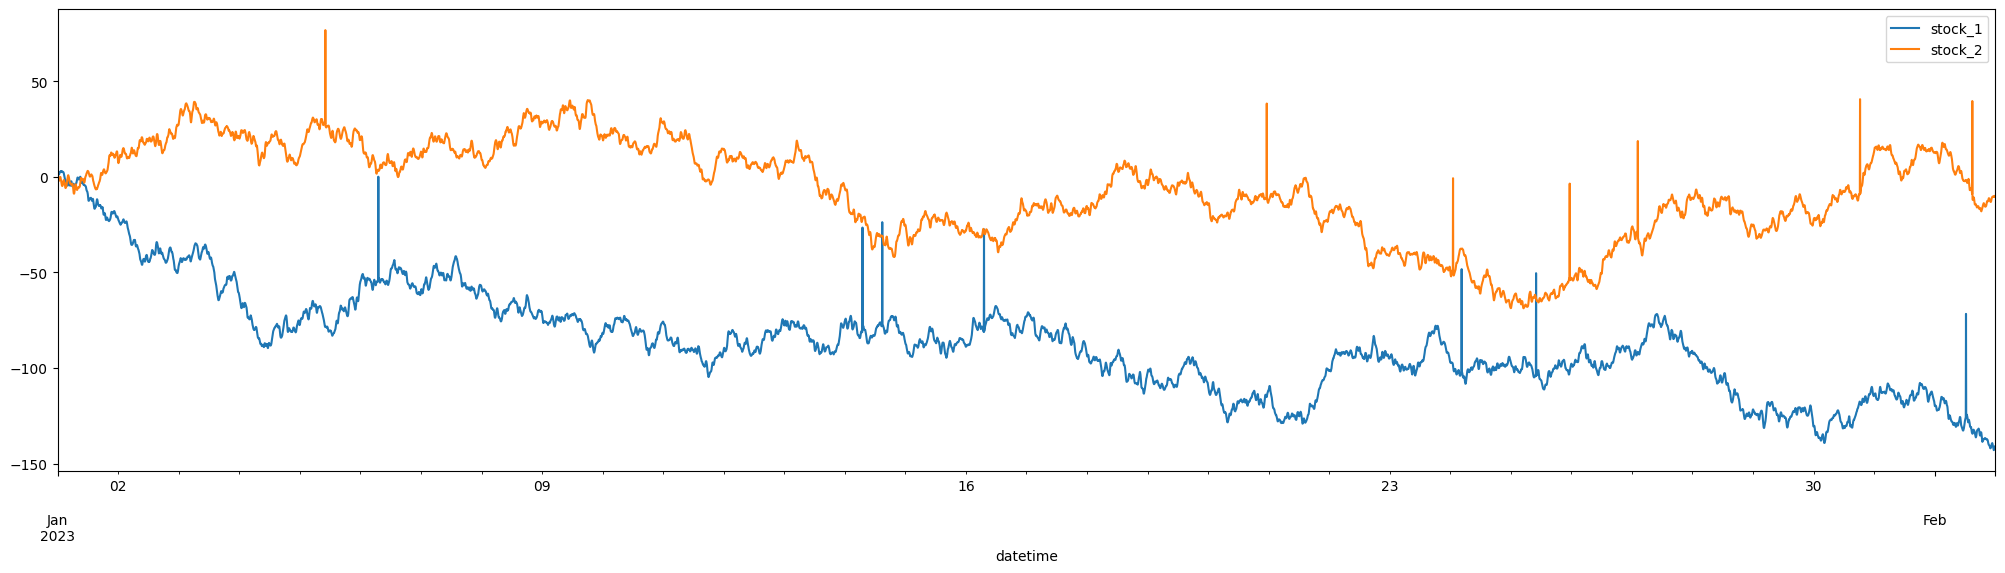

In [4]:
if 'dimension' in df.columns.to_list():
    df[df.dimension=='C'].plot(figsize=(25,6))
else:
    df.plot(figsize=(25,6))

In [5]:
selected_columns = df.columns.to_list()
if 'dimension' in df.columns.to_list():
    selected_columns.remove('dimension')

In [6]:
# Function to create windowed sequences
def create_windows(data, window_size, stride=1):
    X, y = [], []
    for i in range(0, len(data) - window_size, stride):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)
    
    
# Calculate overall mean and std
all_metrics_data = df[selected_columns].to_numpy()

overall_mean, overall_std = np.mean(all_metrics_data, axis=0), np.std(all_metrics_data, axis=0)

In [7]:
# List to store windowed and normalized data for all cell_ids
X_list, y_list = [], []

window_size = 24

if 'dimension' in df.columns.to_list():
    for dim, group in df.groupby('dimension'):
        
        group = group.sort_index()
        # Select only the columns containing the metrics
        metrics_data = group[selected_columns].to_numpy()

        # Normalize the data using the overall mean and std
        metrics_data_normalized = (metrics_data - overall_mean) / overall_std

        # Create windowed sequences
        X_window, y_window = create_windows(metrics_data_normalized, window_size, stride=2)

        # Append to the list
        X_list.append(X_window)
        y_list.append(y_window)
else:
    metrics_data = df[selected_columns].to_numpy()

    # Normalize the data using the overall mean and std
    metrics_data_normalized = (metrics_data - overall_mean) / overall_std

    # Create windowed sequences
    X_window, y_window = create_windows(metrics_data_normalized, window_size, stride=2)

    # Append to the list
    X_list.append(X_window)
    y_list.append(y_window)

In [8]:
X_list = np.concatenate(X_list)
y_list = np.concatenate(y_list)

In [9]:
print(X_list.shape)
print(y_list.shape)

(4597, 24, 2)
(4597, 2)


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

In [11]:
# Split the data into training and validation sets.
split_ratio = 0.8
split_index = int(len(X_list) * split_ratio)
X_train, y_train = X_list[:split_index], y_list[:split_index]
X_val, y_val = X_list[split_index:], y_list[split_index:]
print(X_train.shape)
print(y_train.shape)

(3677, 24, 2)
(3677, 2)


In [12]:
# Step 2: Define a PyTorch Dataset and DataLoader
from torch.utils.data import DataLoader, random_split, TensorDataset
from prediction.nn_models import TimeSeriesDataset

batch_size = 128

train_dataset = TimeSeriesDataset(X_train, y_train,'Train',window_size=window_size, output_size=len(selected_columns))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TimeSeriesDataset(X_val,y_val,'Validation', window_size=window_size, output_size=len(selected_columns))
val_loader = DataLoader(val_dataset,batch_size=batch_size, shuffle=True)

In [13]:
# Reduced model hyperparameters
d_model = len(selected_columns)
nhead = 2  # reduced from 2
num_layers = 2  # reduced from 3
dim_feedforward = 64  # reduced from 128
#batch_size = 32  # reduced from 64

from prediction.nn_models import LSTM_TimeSeriesModel_2
# Initialize the reduced Model, Loss, and Optimizer
# Now we can create a model and send it at once to the device
model = LSTM_TimeSeriesModel_2(d_model, nhead, d_model)

# model = TransformerTimeSeriesModel(d_model, nhead, num_layers, dim_feedforward)

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model.state_dict())

OrderedDict([('lstm.weight_ih_l0', tensor([[-0.3044,  0.2640],
        [ 0.2215, -0.2948],
        [ 0.1216, -0.4413],
        [-0.1393, -0.1075],
        [ 0.3298, -0.3280],
        [-0.3132, -0.3219],
        [-0.5715,  0.1683],
        [ 0.3981, -0.2329]])), ('lstm.weight_hh_l0', tensor([[ 0.3207,  0.5448],
        [-0.6195, -0.6487],
        [-0.0568, -0.2595],
        [ 0.3826, -0.3305],
        [ 0.1633, -0.1438],
        [-0.3340,  0.3203],
        [-0.4392,  0.6777],
        [-0.2934,  0.5808]])), ('lstm.bias_ih_l0', tensor([-0.0049,  0.5753, -0.5508, -0.0420,  0.6279, -0.0324,  0.0628,  0.5293])), ('lstm.bias_hh_l0', tensor([ 0.2815,  0.0964,  0.6651,  0.1718, -0.4627,  0.6319,  0.3853, -0.0545])), ('fc.weight', tensor([[ 0.0580, -0.0508],
        [ 0.1813,  0.1500]])), ('fc.bias', tensor([-0.3247, -0.2832]))])


In [14]:
from prediction.genericReg import *

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader,val_loader)
sbs.set_tensorboard('Anomaly')
sbs.add_graph()
sbs.train(n_epochs=100, print_every=10)
sbs.save_checkpoint('model/model_checkpoint.pth')

print(model.state_dict())

Epoch [10/100]	Training-Loss: 1.0336	Validation Loss: 0.5716
Epoch [20/100]	Training-Loss: 0.6226	Validation Loss: 0.4810
Epoch [30/100]	Training-Loss: 0.4223	Validation Loss: 0.5109
Epoch [40/100]	Training-Loss: 0.3355	Validation Loss: 0.5153
Epoch [50/100]	Training-Loss: 0.3014	Validation Loss: 0.5279
Epoch [60/100]	Training-Loss: 0.2840	Validation Loss: 0.5407
Epoch [70/100]	Training-Loss: 0.2744	Validation Loss: 0.5853
Epoch [80/100]	Training-Loss: 0.2686	Validation Loss: 0.5731
Epoch [90/100]	Training-Loss: 0.2651	Validation Loss: 0.6046
Epoch [100/100]	Training-Loss: 0.2618	Validation Loss: 0.6077
OrderedDict([('lstm.weight_ih_l0', tensor([[-0.1686,  0.2307],
        [ 0.5565, -0.4118],
        [ 0.3474, -0.4331],
        [ 0.2207, -0.3504],
        [ 0.3721,  0.2847],
        [-0.2199, -0.4809],
        [ 0.0265,  0.3201],
        [ 0.8677, -0.2622]], device='cuda:0')), ('lstm.weight_hh_l0', tensor([[ 0.1132,  0.4922],
        [-0.4956, -0.8473],
        [-0.2151, -0.4789],
    

In [15]:
# %tensorboard --port 7000 --logdir runs

In [16]:
model.eval()
all_reconstruction_errors = []

for batch_idx, (X_batch, y_batch) in enumerate(val_loader):
    with torch.no_grad():
        y_pred = sbs.predict(X_batch)
        reconstruction_error = ((y_batch.cpu() - y_pred) ** 2).mean(dim=1).numpy()
        all_reconstruction_errors.extend(reconstruction_error)

all_reconstruction_errors = np.array(all_reconstruction_errors)

In [17]:
import os
reconstruction_checkpt_file = 'all_reconstruction_error.npy'  # Define the path where you want to save the checkpoint
reconstruction_checkpt_file_path = os.path.abspath(os.path.join(os.getcwd(), 'model', reconstruction_checkpt_file))

np.save(reconstruction_checkpt_file_path, all_reconstruction_errors)

In [18]:
import pandas as pd
# Create bins 
bin_ranges = pd.cut(all_reconstruction_errors, bins=50)

# Count the frequency of each bin
bin_counts = bin_ranges.value_counts().sort_index()

# Create a Pandas DataFrame for better visualization
table = pd.DataFrame({
    'Bin_Range': bin_counts.index.astype(str),
    'Frequency': bin_counts.values
})

# Print the table
print(table)

              Bin_Range  Frequency
0   (-0.000777, 0.0365]         87
1      (0.0365, 0.0719]         78
2       (0.0719, 0.107]         41
3        (0.107, 0.143]         12
4        (0.143, 0.178]         28
5        (0.178, 0.214]         21
6        (0.214, 0.249]         33
7        (0.249, 0.285]         30
8         (0.285, 0.32]         17
9         (0.32, 0.356]         20
10       (0.356, 0.391]         16
11       (0.391, 0.426]         11
12       (0.426, 0.462]          8
13       (0.462, 0.497]         16
14       (0.497, 0.533]         15
15       (0.533, 0.568]         20
16       (0.568, 0.604]         23
17       (0.604, 0.639]         10
18       (0.639, 0.675]         16
19        (0.675, 0.71]         12
20        (0.71, 0.746]         17
21       (0.746, 0.781]         20
22       (0.781, 0.817]         20
23       (0.817, 0.852]         26
24       (0.852, 0.887]         28
25       (0.887, 0.923]         36
26       (0.923, 0.958]         19
27       (0.958, 0.9

In [19]:
threshold = np.percentile(all_reconstruction_errors, 99.9)
threshold

1.663779009223

Perform the prediction on the entire dataset now for one of the dimension if it is present

In [20]:
if 'dimension' in df.columns.to_list():
    
    df_ml = df.loc[df['dimension']=='B']
    df_ml = df_ml.sort_index()
else:
    df_ml = df

In [21]:

new_metrics_data = df_ml[selected_columns].to_numpy()

# Using `create_windows` function to create windowed sequences
new_X_window, new_y_window = create_windows(new_metrics_data, window_size)

# Step 4: Normalize the windowed data using original mean and std
new_X_window_normalized = (new_X_window - overall_mean) / overall_std
new_y_window_normalized = (new_y_window - overall_mean) / overall_std



# Create DataLoader if needed
new_dataset = TimeSeriesDataset(new_X_window_normalized, new_y_window_normalized,'All data', window_size=window_size, output_size=len(selected_columns))
new_loader = DataLoader(new_dataset, batch_size=batch_size, shuffle=False)



In [22]:
model.eval()
anomalies = []
filt_reconstruction_errors = []

for batch_idx, (X_batch, y_batch) in enumerate(new_loader):  # Replace val_loader with your test_loader if using new data
    with torch.no_grad():
        y_pred = sbs.predict(X_batch)
        reconstruction_error = ((y_batch.cpu() - y_pred) ** 2).mean(dim=1).numpy()
        
        filt_reconstruction_errors.extend(reconstruction_error)
        batch_anomalies = reconstruction_error > threshold
        anomalies.extend(batch_anomalies)

filt_reconstruction_errors = np.array(filt_reconstruction_errors)
anomalies = np.array(anomalies)
num_anomalies = np.sum(anomalies)
print(f"Number of anomalies: {num_anomalies}")

Number of anomalies: 192


In [23]:
#Here we calculate the number of anomalies based on the pre-calculated Anomaly score (reconstruction_errors)
anomalies_o = filt_reconstruction_errors > threshold
num_anomalies_o = np.sum(anomalies_o)
print(f"Number of anomalies: {num_anomalies_o}")

Number of anomalies: 192


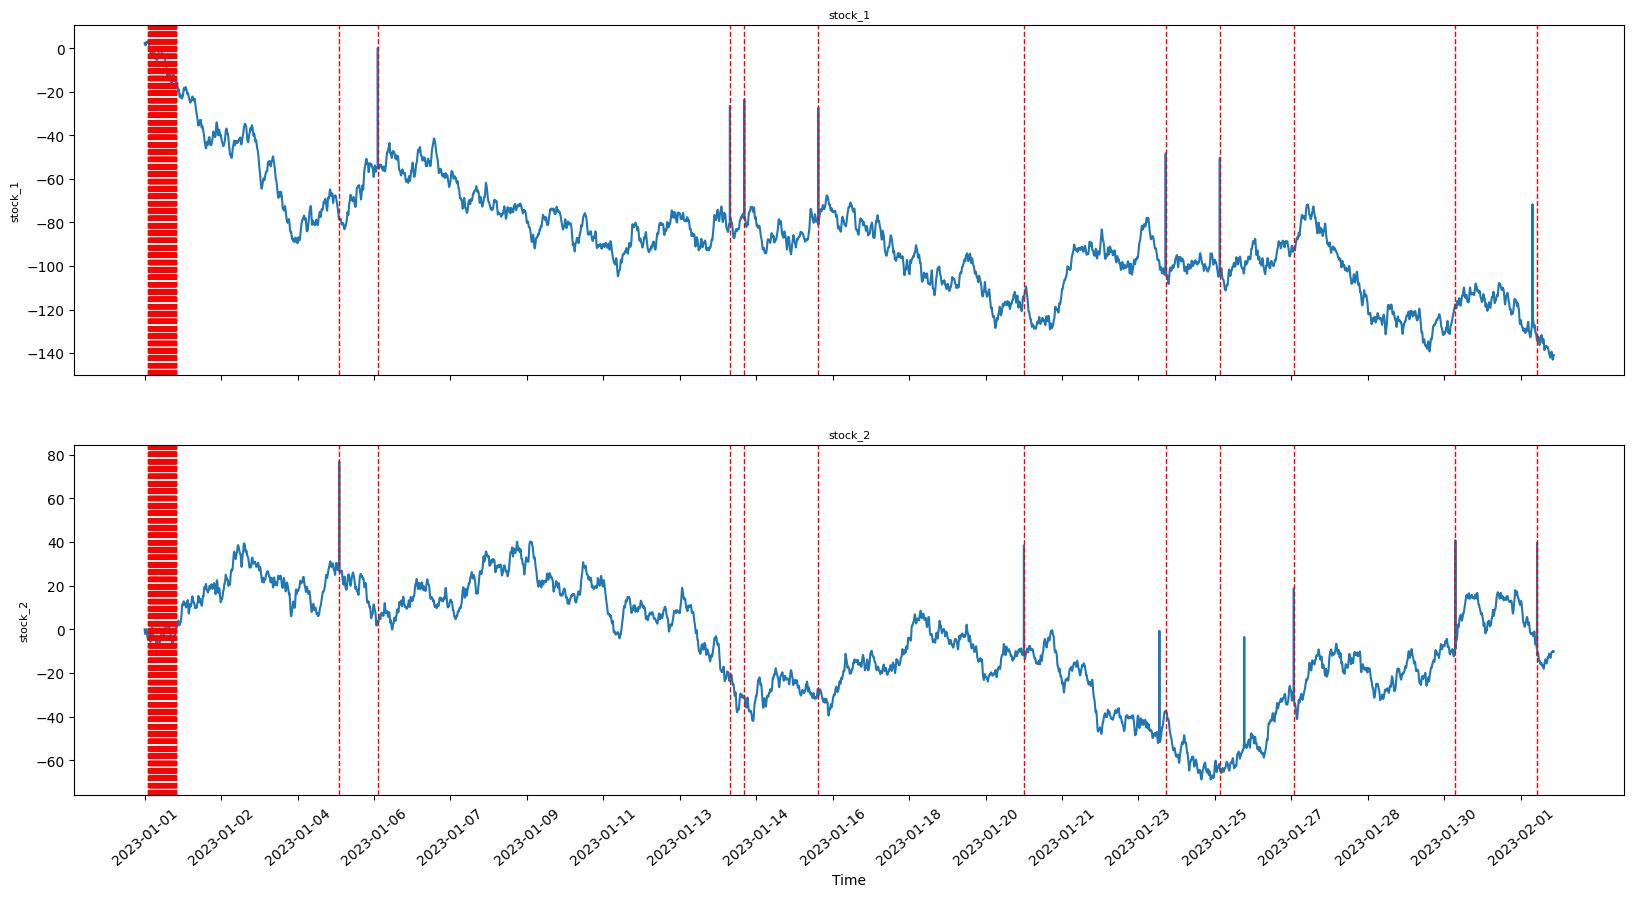

In [24]:

import matplotlib.pyplot as plt

# Prepare anomaly indices (same as previous examples)
anomalous_indexes_val = np.where(anomalies_o)[0]
original_anomalous_indexes = anomalous_indexes_val + window_size
anomaly_times = df_ml.index[original_anomalous_indexes]

# Metrics to be plotted
metrics = selected_columns

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(20, 10), sharex=True)

# Loop through metrics and plot
for i, metric in enumerate(metrics):
    axes[i].plot(df_ml.index, df_ml[metric], label=f'{metric} Data')
    #axes[i].scatter(anomaly_times, pm_data[metric].iloc[original_anomalous_indexes], color='red', label='Anomaly')
    axes[i].set_title(f'{metric}',fontsize=8)
    axes[i].set_ylabel(metric ,fontsize=8)
    for anomaly_time in anomaly_times:
        axes[i].axvline(x=anomaly_time, color='red', linestyle='--', linewidth=1, label='Anomaly')
    #axes[i].legend()


# Label the shared x-axis
axes[-1].set_xlabel('Time')
ticks_to_use = df_ml.index[::500]  # Choose every 10th time point
plt.xticks(ticks_to_use)
plt.xticks(rotation=40)

# Show plot
plt.show()